# Audio Signal Processing for Machine Learning

**Martin Sanchez Pueyo**

This notebook contains several methods of audio signal preprocessing for machine learning applications.

**TODO:**
* 2.3. Fourier Transform: Expand fourier continuous and discrete transform mathematical explanation.
* 2.4. Mel Spectograms: Expand mel spectogram mathematical explanation.
* 3.X. Audiocommons timbral models: Add information

In [1]:
import numpy as np
import scipy as sp
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa
import librosa.display

FIG_SIZE = (15, 4)

## 1. Sound and waveforms

**Sound** is produced by vibration of an object that causes air molecules to oscillate which generates a change in air pressure which is defined as a wave. A **mechanical wave** is an oscillation that travels though space in which the medium is deformed by the energy that travels from one point to another. A **waveform** carries multifactorial information such as frequency, intensity or timbre.

Sound can be divided into 2 categories: **Periodic** and **aperiodic** sound. Periodic sound can be described as a single sinewave or the linear combination of multiple sinewaves wile aperiodic can be continuous (noise) or transient (pulse).

A **sinewave** is described as
$$y(t) = A \sin(2 \pi f t + \phi)$$
With an amplitude $A$, frequency $f$ and phase $\phi$. Its period is defined as $T = \frac{1}{f}$.

Human hearing range goes from approximately 20 to 20,000 Hz. **Pitch** is a logarithmic perception for frequency, they are related in the following way.

$$F(p)=2^{\frac{p-69}{12}} \cdot 440$$

### 1.1. Intensity, loudness and timbre

**Sound power** is the rate at which energy is transferred. It is measured in watts ($W$) and can be computed as the energy per unit of timed by a sound source in all directions accross the media in which the sound is travelling in.

**Sound intensity** is the sound power per unit area and can be measured in $W/m^2$. Humans can perceive sounds with very small intensities. **Threshold of hearing** is considered to be at $TOH = 10^{-12} W/m^2$. Threshold that can produce irreversible heard damage (**Threshold of pain**) is $TOP = 10 W/m^2$.

As we are working in a range of several orders of magnitude, intensity level is defined in Logarithmic scale and is measured in decibels (dB) which is the ratio between intensity and another intensity of reverence (Usually is the TOH). So 0 dB is the Threshold of hearing. In around 3 dBs difference, intensity doubles.

$$dB(I)=10 \log{\frac{I}{I_{TOH}}}$$

**Loudness** is a subjective perception of sound intensity, but it also depends on duration and frequency of a sound. It depens on the age of the person who is hearing and is measured in phons.

**Timbre** defines the colour of sound and explains why 2 sounds with the same intensity, frequency and duration may be different between them. It is a multidimensaial variable.

**Sound envelope** is usually explained using the ADSR Model (Attack-Decay-Sustain-Release) which represent how the intensity of the sound evolves over time.

A complex sound can be described as a superposition of sinusoids in which a partial is one of each of the components. The lowest one is called the "fundamental frequency". and all others are multiples of this one. Inharmonicity is described a deviation for the harmonic partial.

Sound can also have frequency or amplitude modulation. **Frequency modulation** is a periodic variation in pitch which is usually used for expressive purposes and is commonly known as *'vibrato'*. **Amplitude modulation** is similar but at amplitude level, it is usually known as *'tremolo'*. 

### 1.2. Understandig audio signals

Audio signals are a representation of sound and encodes all the information needed to reproduce the sound. The main problem of this approach is that sound is a mechanical, analogical wave and is being processed with digital tools. The **analog signal** has continuous values for time and amplitude while the **digital signal** has a sequence of discrete values in which data points can only take a finite number of values.

**Analog to digital conversion** (ADC) requires sampling and quantization processes. This is called *'Pulse-code modulation'*. Each of the snapshot is called a sample that occurs in a defined period $T$.

$$t_n = n \cdot T$$

The **sample rate** defines the frequency at which each sample is taken $s_r = \frac{1}{T}$. Higher sampling rates will increase the amount of data by increasing the fidelity of the conversion. Sampling rate for sound is usually defined at 44,100 Hz. This number is obtained because of the Nyquist Frequency which is the limit in which an audible signal will start to generate artifacts. The most common artifact generated by low sampling rates is Aliasing in which the frequency of a signal can be mistakenly reconstructed as a lower frequency one.

**Quantization** is the process in which the amplitude is discretized. The resolution is called bit depth and is the number of bits in which the sound can be encoded. In CDs this is usually 16 bits which allow up to 65536 different values.

**Dynamic range** is the difference between the largest and smallest signal that a system can record. It is associated with the signal to quantization noise ratio $SQNR \approx 6.02 \cdot Q$. Para 16 bits, el rango dinámico es de 96 dB.

## 2. Audio features 

Can be splitted in three levels of abstraction:

* High Level: Instrumentation, key, chords, melody, rythm...
* Mid Level: Pitch and beat descriptors, note onsets, fluctuation patterns, MFCCs...
* Low Level: Amplitude envelope, energy, spectral centroid, spectral flux, zero-crossing rate...

*Knees, P. & Schedl, M. (2016). Music Similarity and retrieval.*

The temporal scope can be instantaneous (around 50 ms), at segment level (seconds) or global. Musical ascpects are described to beat, timbre, pitch, harmony.

The signal can be described either on the time domain or the frequency domain. On the **time domain** some features that can be extracted are the amplitude envelope, root-mean square energy or zero crossing rate. On the **frequency domain** the band energy ratrio, spectral centroid or spectral flux are found. There are also time-frequency representations such as the spectrogram, mel-spectogram or constant-Q transform.

In traditional machine learning the approach usually used was to extract all audio features, and then choose the ones that are believed to be better for the problem's purpose, for this, DSP would be used based on the selected features and operate in rule-based systems. In a deep learning approach, a whole spectogram is feeded to a network to solve the problem so the algorithm is able to extract features by themselves.



### 2.1. Extracting audio features.

At 44.1 kHz, 1 sample is the equivalent to 0.027 ms of audio, human hearing threshold is around 10 ms and all the features are related to how humans experience sound. To have a power of 2 number of samples will improve the performance of several audio processing algorithms such as the fast fourier transform so it is preferred to use it. Typical values are 256-8192.

$$d_f = \frac{1}{s_r}\cdot K$$

On the time domain feature pipeline, for each frame the features are computed and an aggregator is ued such us the mean, median or GMM and from this process a feature vector is extracted. On the frequency domain feature pipeline, for each frame the frame is transformed using the Fourier transform.

Spectral leakage may occur when a processed signal is not an integer number of periods which is usually the case when splitting the sample into frames. This discontinuities appear as high frequency components that do not exist on the original signal. To solve this is issue, a windowing function is applied to each frame which eliminates samples at both ends of the frame. Most usual windowing algorithm is the Hann window. Windowing leads to a problem in which signal is lost due to the application of the windowing function so frames needs to be overlapped to avoid losing information; a parameter that defines how many samples are shifted is the hop distance or hop size.

Once windowing is applied, features can be computed and aggregated as was done in the time domain getting another vector.

In [2]:
# Load audio files
sample_file = "resources/kickme.wav"
ipd.Audio(sample_file)

In [3]:
sample, sr = librosa.load(sample_file, sr=44100, mono=True)

print("Sampling rate: {} Hz".format(sr))
print("Sample size: {}".format(sample.size))
print("Sample duration: {} s".format(sample.size/sr))

Sampling rate: 44100 Hz
Sample size: 5189
Sample duration: 0.11766439909297052 s


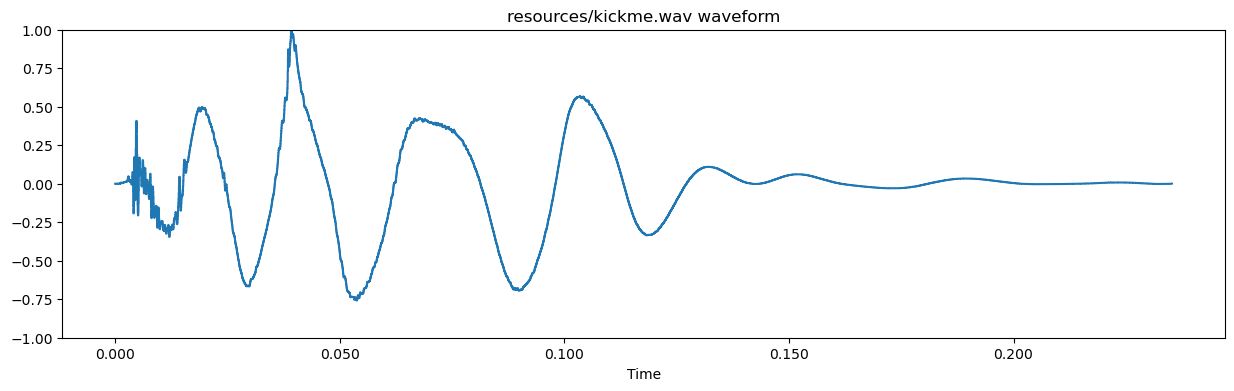

In [4]:
# Waveform
plt.figure(figsize=FIG_SIZE)
librosa.display.waveshow(sample)
plt.title("{} waveform".format(sample_file))
plt.ylim(-1, 1)
plt.show()


### 2.2. Time domain features

The amplitude envelope is the maximum amplitude value of all samples in a frame. It gives a rough idea of loudness but is very sensitive to outliers. It is good for onset detection or music genre classification.

In [5]:
def amplitude_envelope(signal, frame_length, hop_length):
    amplitude_envelope = []
    for i in range(0, len(signal), hop_length):
        current_frame_amplitude_envelope = max(signal[i:i+frame_length])
        amplitude_envelope.append(current_frame_amplitude_envelope)
    return np.array(amplitude_envelope)

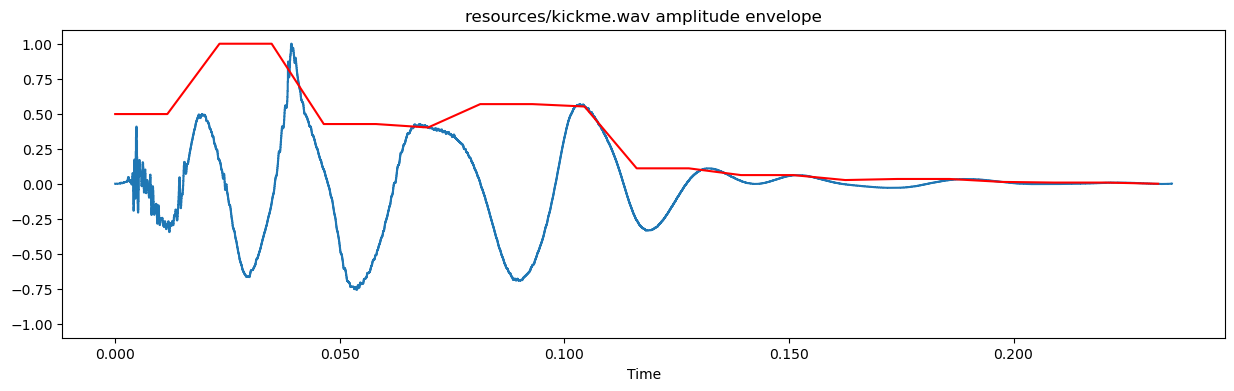

In [6]:
FRAME_LENGTH = 512
HOP_LENGTH = 256

ae = amplitude_envelope(sample, FRAME_LENGTH, HOP_LENGTH)

frames = range(0, ae.size)
t = librosa.frames_to_time(frames, hop_length=HOP_LENGTH)

plt.figure(figsize=FIG_SIZE)
librosa.display.waveshow(sample)
plt.plot(t, ae, color='r')
plt.title("{} amplitude envelope".format(sample_file))
plt.show()

The root-mean-square energy is computed as the RMS of all samples in a frame. It is an indicator of roughtness and is less sensitive to outliers. It is widely used for audio segmentation or music genre classification.

In [7]:
def rms(signal, frame_length, hop_length):
    rms = []
    for i in range(0, len(signal), hop_length):
        rms_current_frame = np.sqrt(np.sum(signal[i:i+frame_length]**2) / frame_length)
        rms.append(rms_current_frame)
    return np.array(rms)

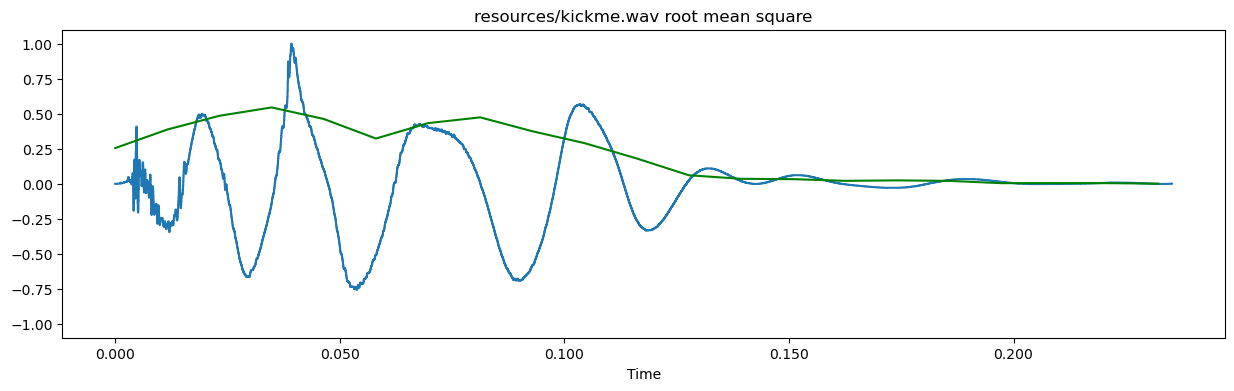

In [8]:
FRAME_LENGTH = 512
HOP_LENGTH = 256

#rms = librosa.feature.rms(y=sample, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)[0]
rms = rms(sample, FRAME_LENGTH, HOP_LENGTH)

frames = range(0, rms.size)
t = librosa.frames_to_time(frames, hop_length=HOP_LENGTH)

plt.figure(figsize=FIG_SIZE)
librosa.display.waveshow(sample)
plt.plot(t, rms, color='g')
plt.title("{} root mean square".format(sample_file))
plt.show()

The zero crossing rate is the number of times a signal crosses the horizontal axis. It is used for recognizing percussive or pitched sounds, monophonic pitch estimation, and to decide wether a sound is speech or not.

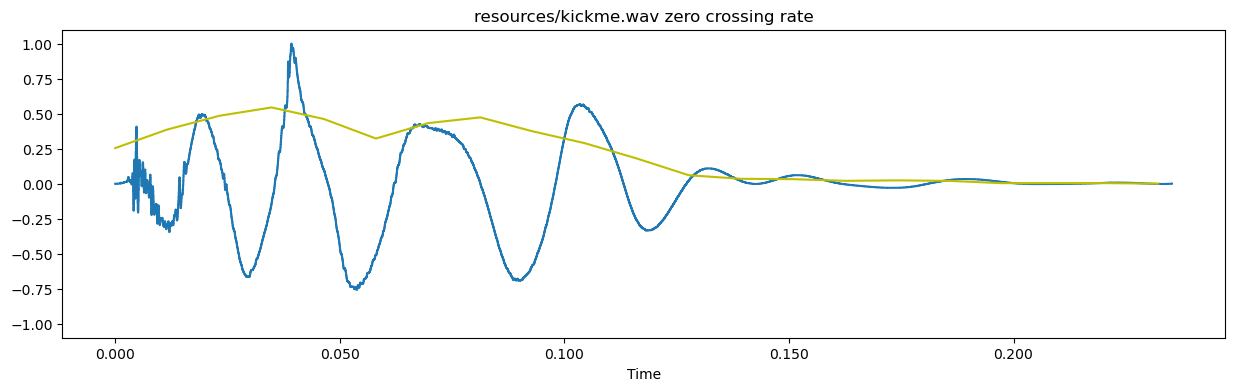

In [9]:
FRAME_LENGTH = 512
HOP_LENGTH = 256

zcr = librosa.feature.zero_crossing_rate(y=sample, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)[0]

frames = range(0, zcr.size)
t = librosa.frames_to_time(frames, hop_length=HOP_LENGTH)

plt.figure(figsize=FIG_SIZE)
librosa.display.waveshow(sample)
plt.plot(t, rms, color='y')
plt.title("{} zero crossing rate".format(sample_file))
plt.show()

### 2.3. Fourier transform

It allows to compare signal with sinusoids of various frequencies. For each frequency a magnitude and phase is computed. High magnitude indicates likelihood between the signal and that sinusoid.

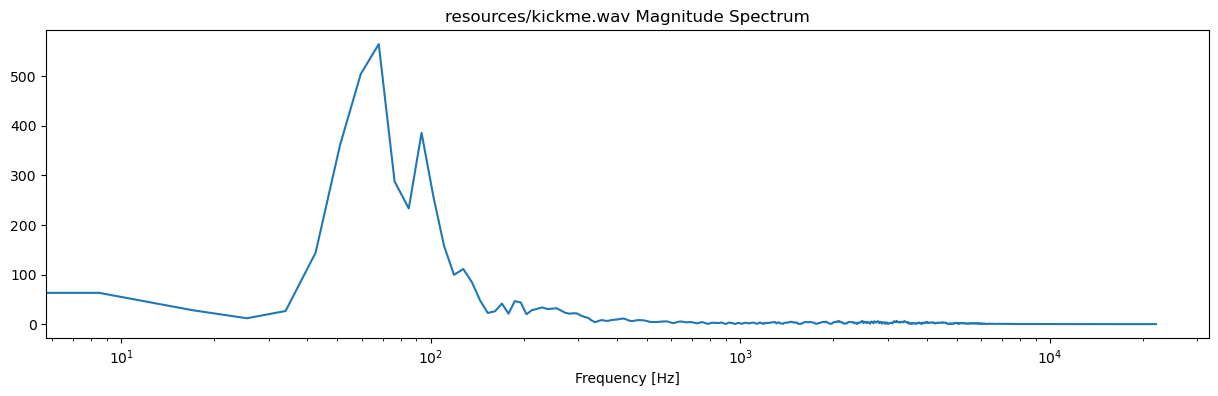

In [10]:
def plot_magnitude_spectrum(signal, title, sr, f_ratio=0.5, x_axis='log'):
    ft = sp.fft.fft(signal)
    magnitude_spectrum = np.abs(ft)

    frequency = np.linspace(0, sr, len(magnitude_spectrum))
    num_frequency_bins = int(len(frequency) * f_ratio)

    plt.figure(figsize=FIG_SIZE)
    plt.plot(frequency[0:num_frequency_bins], magnitude_spectrum[0:num_frequency_bins])
    plt.title(title)
    plt.xlabel("Frequency [Hz]")
    plt.xscale(x_axis)
    plt.show()

plot_magnitude_spectrum(sample, "{} Magnitude Spectrum".format(sample_file), sr)

A problem about the Fourier transform is that it takes it data from the complete audio sample so it is known what is the sound composed from but not when. The Short-time-Fourier-transform (STFT) solves this by windowing the sample into a set of smaller signals and apply the transform to each of the slices.

In [11]:
def plot_spectogram(Y, sr, hop_length, y_axis='linear'):
    plt.figure(figsize=FIG_SIZE)
    librosa.display.specshow(Y, sr=sr, hop_length=hop_length, x_axis='time', y_axis=y_axis)
    plt.colorbar(format='%+2.f')
    plt.xlabel('Time')

Shape of STFT result: (257, 21)


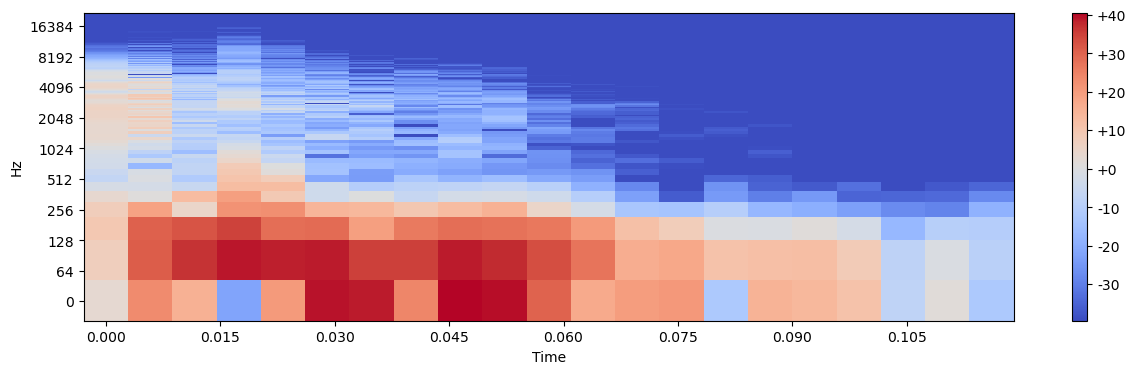

In [12]:
FRAME_LENGTH = 512
HOP_LENGTH = 256

S = librosa.stft(sample, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH)
Y = np.abs(S)**2
Y_log = librosa.power_to_db(Y)

print("Shape of STFT result: {}".format(S.shape))
plot_spectogram(Y_log, sr, HOP_LENGTH, y_axis='log')

### 2.4. Mel-Spectogram

It is extensively used in AI audio applications. It is a time-frequency representation that offers perceptually relevant amplitude and frequency representations. It can be computed as:

$$f = 2595 \cdot \log{(1+\frac{f}{500})}$$

To extract it, the next steps are followed:
* Extract STFT.
* Convert amplitude to DBs.
* Convert frequencies to Mel scale.

For the last step, mel filter banks are created by following the formula for converting between Mels and Hertz. In this steps, the number of bands is created by equally spaced points and these points are converted back to Hertz. Later on, these are rounded to the nearest frequency bin and triangular filters are created and applied to the spectrogram.

These spectograms are used for audio classification, automatic mood recognition, music genre classification and music instrument classification.

In [13]:
filter_banks = librosa.filters.mel(n_fft=2048, sr=22050, n_mels=10)

Text(0.5, 0, 'Time')

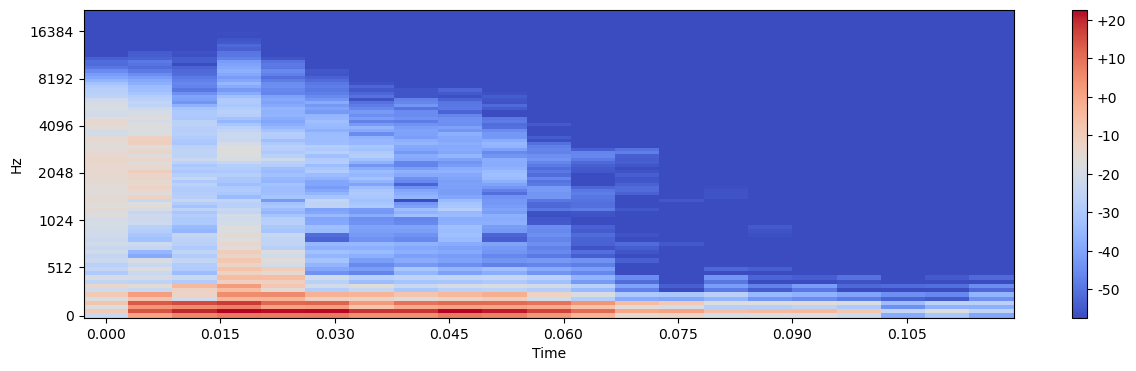

In [14]:
FRAME_LENGTH = 512
HOP_LENGTH = 256
N_MELS = 90

mel_spectrogram = librosa.feature.melspectrogram(y=sample, sr=sr, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH, n_mels=N_MELS)
log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)

plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(log_mel_spectrogram, sr=sr, hop_length=HOP_LENGTH, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.f')
plt.xlabel('Time')

### 2.5. Mel-Frequency Cepstral Coefficients

Cepstrum is the result of applying the inverse fourier transform (IFT) of the logarithm of the estimated signal spectrum. In other words, it is the spectrum of a spectrum. It was developed for studying seismic signals but also applied in audio feature for speech recognition and music processing. It is computed as:

$$C(x(t)) = F^{-1}[log(F[x(t)])]$$

To compute the Mel-Frequency Cepstral Coefficients, first the DFT is applied and then thje Log-Amplitude Spectrum is computed. This spectrum can be Mel-Scaled and then the Discrete Cosine Transform (DCT) can be performed to obtain the MFCCs. The DCT is a simplified version of the Fourier Transform that gets the real-valued coefficient. It decorrelates the energy in different Mel bands and reduces the number of dimensions needed to represent the spectrum.

Usually, the first 11-13 coefficients are computed as are the ones that keep most information (Formants, Spectral Envelope). It is also possible to compute the second and third order MFCCs obtaining a total of 39 coefficients per frame.

The MFCCs describe large structures in the spectrum, ignore fine spectral structures and work well in speech and music preprocessing. However, they are not robust to noise, require extensive knowledge engineering and are not efficient for synthesis.

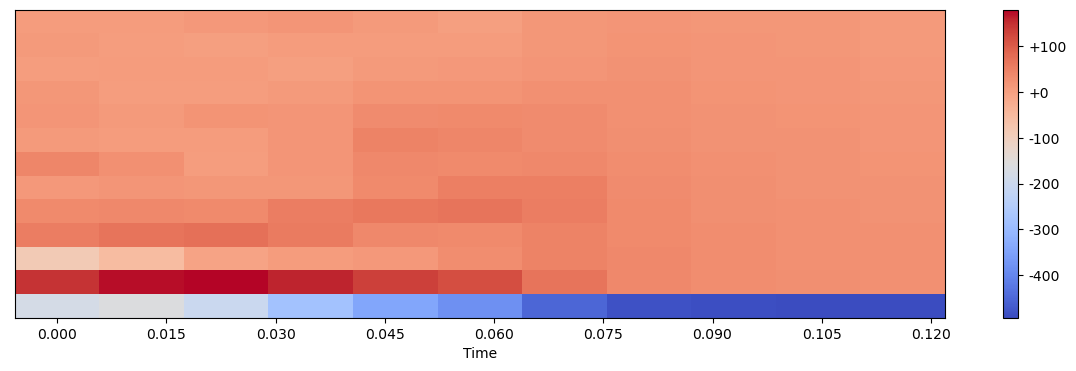

In [15]:
mfccs = librosa.feature.mfcc(y=sample, n_mfcc=13, sr=sr)

plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(mfccs, sr=sr, x_axis='time')
plt.colorbar(format='%+2.f')
plt.show()

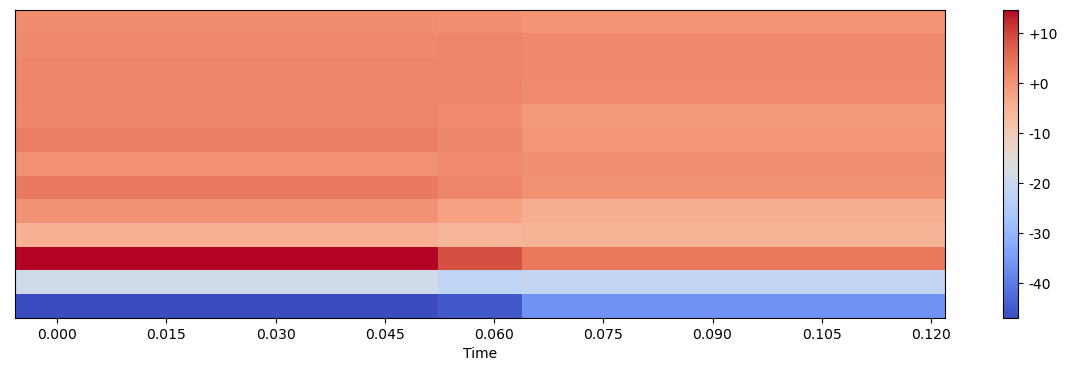

In [16]:
delta_mfccs = librosa.feature.delta(mfccs)

plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(delta_mfccs, sr=sr, x_axis='time')
plt.colorbar(format='%+2.f')
plt.show()

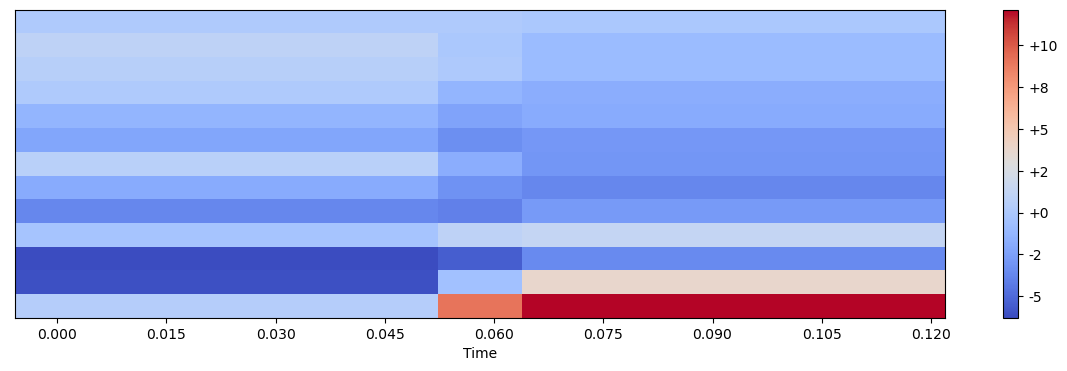

In [17]:
delta2_mfccs = librosa.feature.delta(mfccs, order=2)

plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(delta2_mfccs, sr=sr, x_axis='time')
plt.colorbar(format='%+2.f')
plt.show()

In [18]:
all_mfccs = np.concatenate((mfccs, delta_mfccs, delta2_mfccs))

### 2.6. Frequency-domain audio features

The band energy ratio (BER) is a comparison of energy in the lower and higher frequency bands. It is a measure of how dominant low frequencies are. It is used for music / speech discrimination and music classification.

In [21]:
def get_frequency_bin(spectrogram, split_frequency, sample_rate):
    frequency_range = sample_rate / 2
    f_delta_bin = frequency_range / spectrogram.shape[0]
    split_frequency_bin = np.floor(split_frequency / f_delta_bin)
    return int(split_frequency_bin)

def get_ber(spectrogram, split_frequency, sample_rate):
    split_frequency_bin = get_frequency_bin(spectrogram, split_frequency, sample_rate)

    power_spec = np.abs(spectrogram) ** 2
    power_spec = power_spec.T

    band_energy_ratio = []
    for frequencies_in_frame in power_spec:
        sum_power_low_frequencies = np.sum(frequencies_in_frame[:split_frequency_bin])
        sum_power_high_frequencies = np.sum(frequencies_in_frame[split_frequency_bin:])
        ber_current_frame = sum_power_low_frequencies / sum_power_high_frequencies
        band_energy_ratio.append(ber_current_frame)
    return np.array(band_energy_ratio)

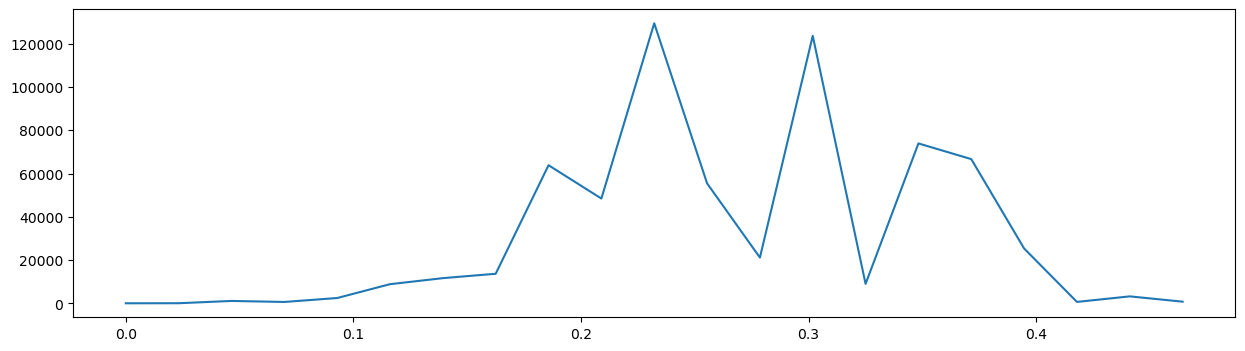

In [24]:
ber = get_ber(S, 2000, sr)

frames= range(len(ber))
t = librosa.frames_to_time(frames)

plt.figure(figsize=FIG_SIZE)
plt.plot(t, ber)
plt.show()

The spectral centroid (SC) is the centre of gravity of the magnitude spectrum. It s the frequency band where most of the energy is concentrated and measures the 'brightness' of the sound. It is computed as the weighted mean of the frequencies. It is extensively used in audio classification and music classification.

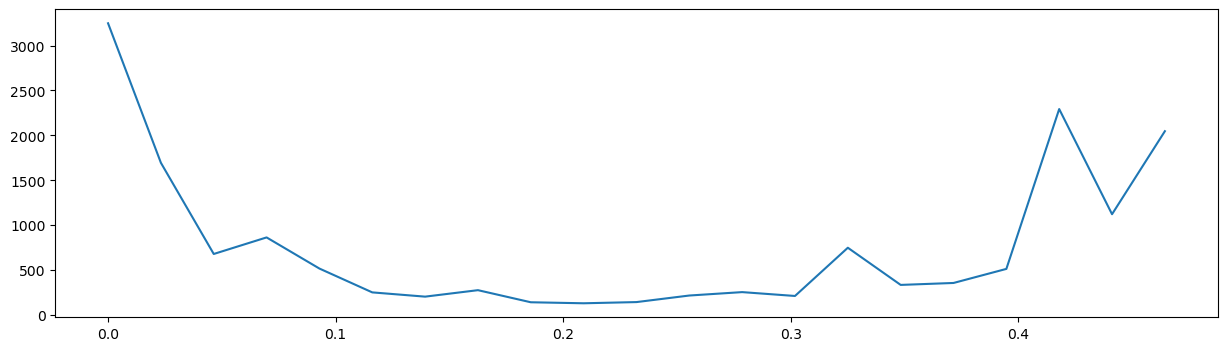

In [26]:
FRAME_LENGTH = 512
HOP_LENGTH = 256

sc = librosa.feature.spectral_centroid(y=sample, sr=sr, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH)[0]

plt.figure(figsize=FIG_SIZE)
plt.plot(t, sc)
plt.show()

The bandwidth (BW) is derived from the spectral centroid and represents the range or variance around it. It is able to describe the perceived timbre. It ius computed as the weighted mean of the distances of frequency bands from the SC. It is widely used in music processing.

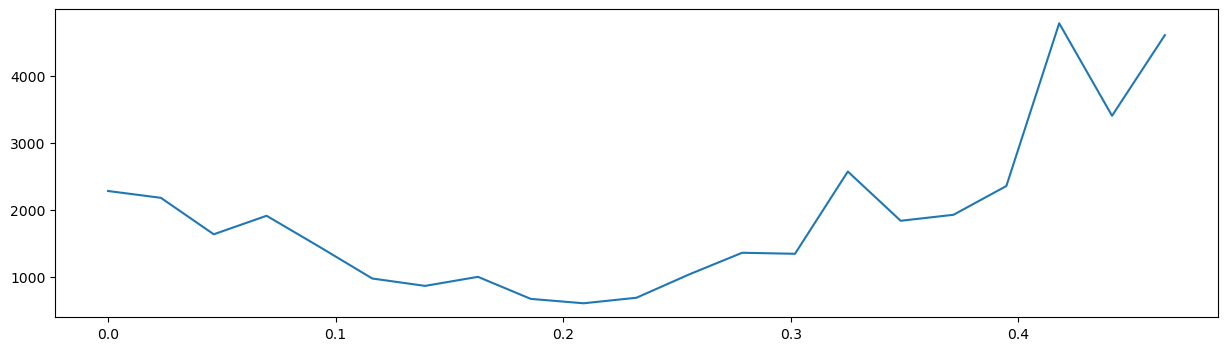

In [27]:
FRAME_LENGTH = 512
HOP_LENGTH = 256

bw = librosa.feature.spectral_bandwidth(y=sample, sr=sr, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH)[0]

plt.figure(figsize=FIG_SIZE)
plt.plot(t, bw)
plt.show()

## 3. Audiocommons Timbral Models